# Replicate results on the Poker DVS dataset for the Grimaldi et al. 2021 paper

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

from network import network
from tools import get_loader, get_dataset_info, fit_MLR, predict_MLR, score_classif_events, score_classif_time, fit_histo, predict_histo
import os, tonic

def printfig(fig, name):
    dpi_exp = None
    bbox = 'tight'
    path = '../../paper/5f22d412742c360001c92b46/fig/'
    #path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
    fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS


## TODO
- classification when trying different clustering
- classification as a function of jitter

## Information about the dataset

number of samples in the trainset: 48
number of samples in the testset: 20
----------------------------------------
number of samples in each class for the trainset: [12. 12. 12. 12.]
number of samples in each class for the testset: [5. 5. 5. 5.]
----------------------------------------


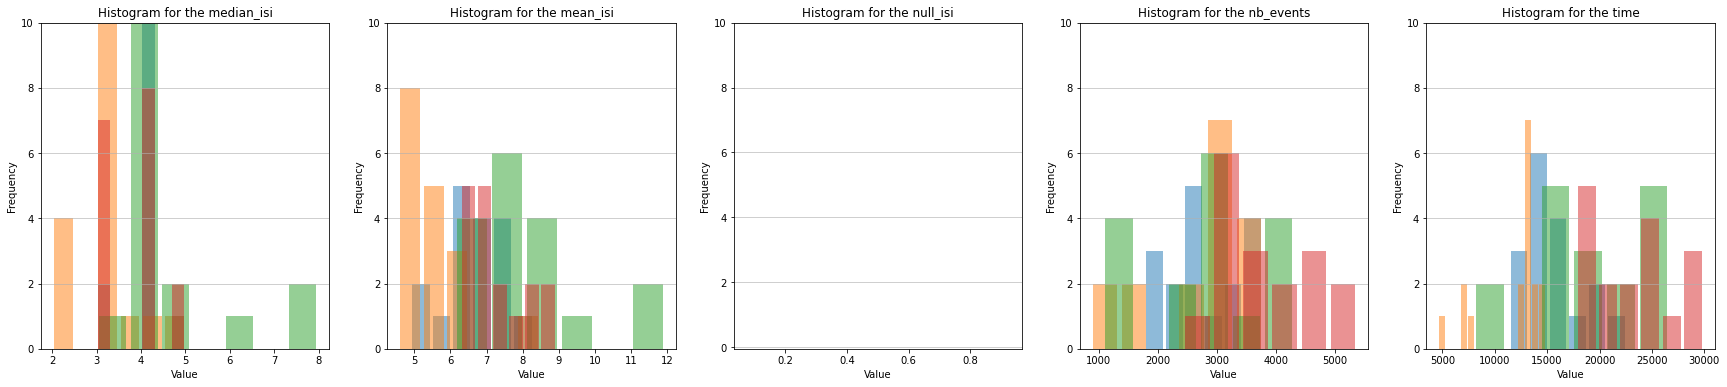

In [3]:
trainset = tonic.datasets.POKERDVS(save_to='../../Data', train = True, transform = tonic.transforms.NumpyAsType(int))
testset = tonic.datasets.POKERDVS(save_to='../../Data', train = False, transform = tonic.transforms.NumpyAsType(int))
values = get_dataset_info(trainset,testset, properties = ['median_isi', 'mean_isi', 'null_isi', 'nb_events', 'time'], distinguish_labels=True)

## Define the hyperparameters of the network

In [5]:
#for poker DVS
sensor_size = trainset.sensor_size
name = 'homhots'
tau = (0.3*2,0.3*4,0.3*8)
homeo = (3,0)
timestr = '2022-01-06_poker'

loading a network with name:
 ../Records/models/2022-01-06_poker_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl


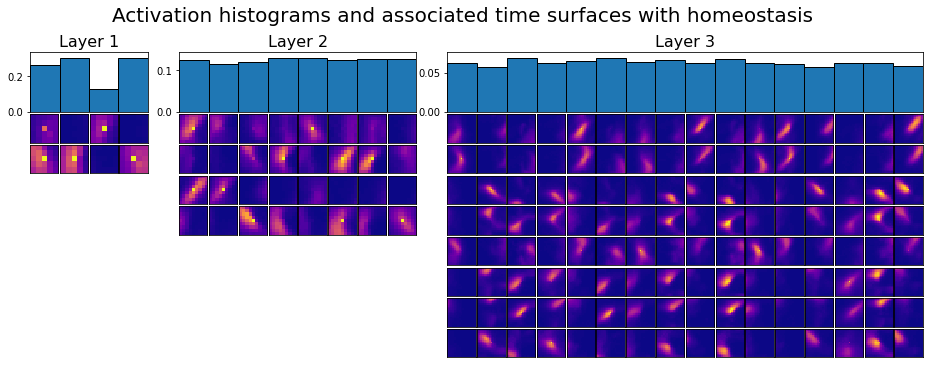

In [4]:
hots = network(name = name, tau = tau, homeo = homeo, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))
loader = get_loader(trainset)
hots.running(loader, trainset.ordering, trainset.classes, learn=True, train=True)
hots.plotlayer();

# Online classification performance
## Classification with the output of the network

In [5]:
tau_cla = 15
hots.running(loader, trainset.ordering, trainset.classes, train=True)
model, loss = fit_MLR(tau_cla, network = hots)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Name of the model: 
 ../Records/models/2022-01-06_poker_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_15_None_LR.pkl


this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
../Records/output/classif/2022-01-06_poker_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_15_None_None_LR.pkl
Mean accuracy: 98.9%
Accuracy with classification at the last event: 100%


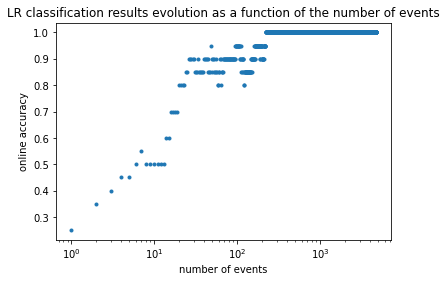

In [6]:
loader = get_loader(testset)
hots.running(loader, trainset.ordering, trainset.classes, train=False)
likelihood, true_target, timestamps = predict_MLR(model, tau_cla, network = hots)
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)
print(f'Accuracy with classification at the last event: {int(lastac*100)}%')

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 60.35it/s]
/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS/tools.py:439: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy: 93.7%
Accuracy with classification at the last event: 100%


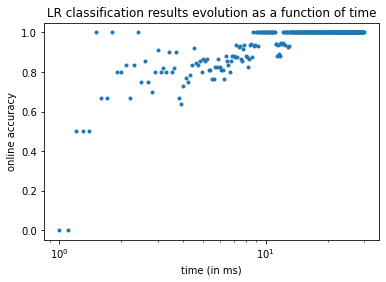

In [7]:
timestep = 100
meanac, onlinac, lastac, truepos, falsepos = score_classif_time(likelihood, true_target, timestamps, timestep, thres=None)
print(f'Accuracy with classification at the last event: {int(lastac*100)}%')

## Classification with raw event stream (control)

In [8]:
sensor_size = trainset.sensor_size
transform = transform = tonic.transforms.Compose([tonic.transforms.ToTimesurface(sensor_size=sensor_size, tau=tau_cla, decay="exp")])
trainset_as_input = tonic.datasets.POKERDVS(save_to='../../Data', train = True, transform = transform)

Name of the model: 
 ../Records/models/2022-01-06_poker_raw_15_None_LR.pkl
../Records/output/classif/2022-01-06_poker_raw_15_None_None_LR.pkl
Mean accuracy: 74.1%


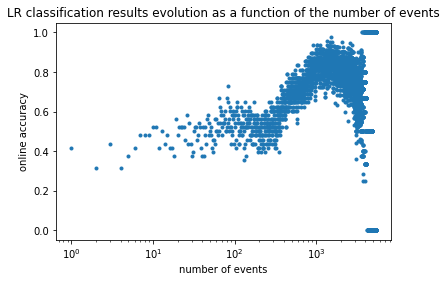

In [9]:
model, loss = fit_MLR(tau_cla, date = timestr, dataset_as_input = trainset_as_input)
likelihood, true_target, timestamps = predict_MLR(model, tau_cla, date = timestr, dataset_as_input = trainset_as_input, dataset_for_timestamps_as_input = trainset)
meanac, onlinac, lastac, truepos, falsepos = score_classif_events(likelihood, true_target)

  0%|                                                                                                                                                         | 0/48 [00:00<?, ?it/s]/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/INT/grimaldi.a/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 59.19it/s]
/home/INT/grimaldi.a/Documents/projets/HOTS/newhots/HOTS/tools.py:439: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy: 71.7%


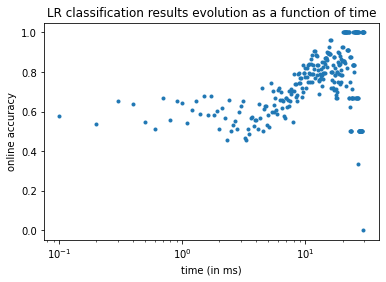

In [10]:
meanac, onlinac, lastac, truepos, falsepos = score_classif_time(likelihood, true_target, timestamps, timestep, thres=None)

# Classification with histogram 

In [11]:
histo, label = fit_histo(hots)

Number of training samples: 48
load existing histograms


In [12]:
k = 8
accuracy = predict_histo(hots, histo, label, k=k)
print(f'Accuracy for {k}-NN classifier: {accuracy*1e2}%')

Number of testing samples: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 2188.69it/s]

Accuracy for 8-NN classifier: 80.0%


## Trying different clusterings

In [ ]:
train_loader = get_loader(trainset)
test_loader = get_loader(trainset)
ACC = []
k = 6
for trial in range(100):
    timestr = f'2022-01-06_poker_{trial}'
    hots = network(name = name, tau = tau, homeo = homeo, timestr = timestr, camsize=(sensor_size[0], sensor_size[1]))
    hots.running(train_loader, trainset.ordering, trainset.classes, learn=True, train=True)
    hots.running(train_loader, trainset.ordering, trainset.classes, learn=False, train=True)
    hots.running(test_loader, trainset.ordering, trainset.classes, learn=False, train=False)
    histo, label = fit_histo(hots)
    ACC.append(predict_histo(hots, histo, label, k=k))

loading a network with name:
 ../Records/models/2022-01-06_poker_0_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_0_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_0_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1037.04it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_1_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_1_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_1_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2088.93it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_2_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_2_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_2_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2082.25it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_3_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_3_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_3_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2034.75it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_4_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_4_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_4_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2066.18it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_5_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_5_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_5_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2049.77it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_6_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_6_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-01-06_poker_6_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/
Number of training samples: 48
load existing histograms
Number of testing samples: 48


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2042.78it/s]


loading a network with name:
 ../Records/models/2022-01-06_poker_7_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8].pkl
this dataset have already been processed, check at: 
 ../Records/output/train/2022-01-06_poker_7_homhots_(3, 0)_[4, 8, 16]_[0.6, 1.2, 2.4]_[2, 4, 8]_None/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:14<00:00,  2.80s/it]


Number of training samples: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 1855.89it/s]


Number of testing samples: 48


 31%|█████████████████████████████████████████████                                                                                                   | 15/48 [00:39<01:32,  2.81s/it]